# «Выявление фейковых новостей в медиа»

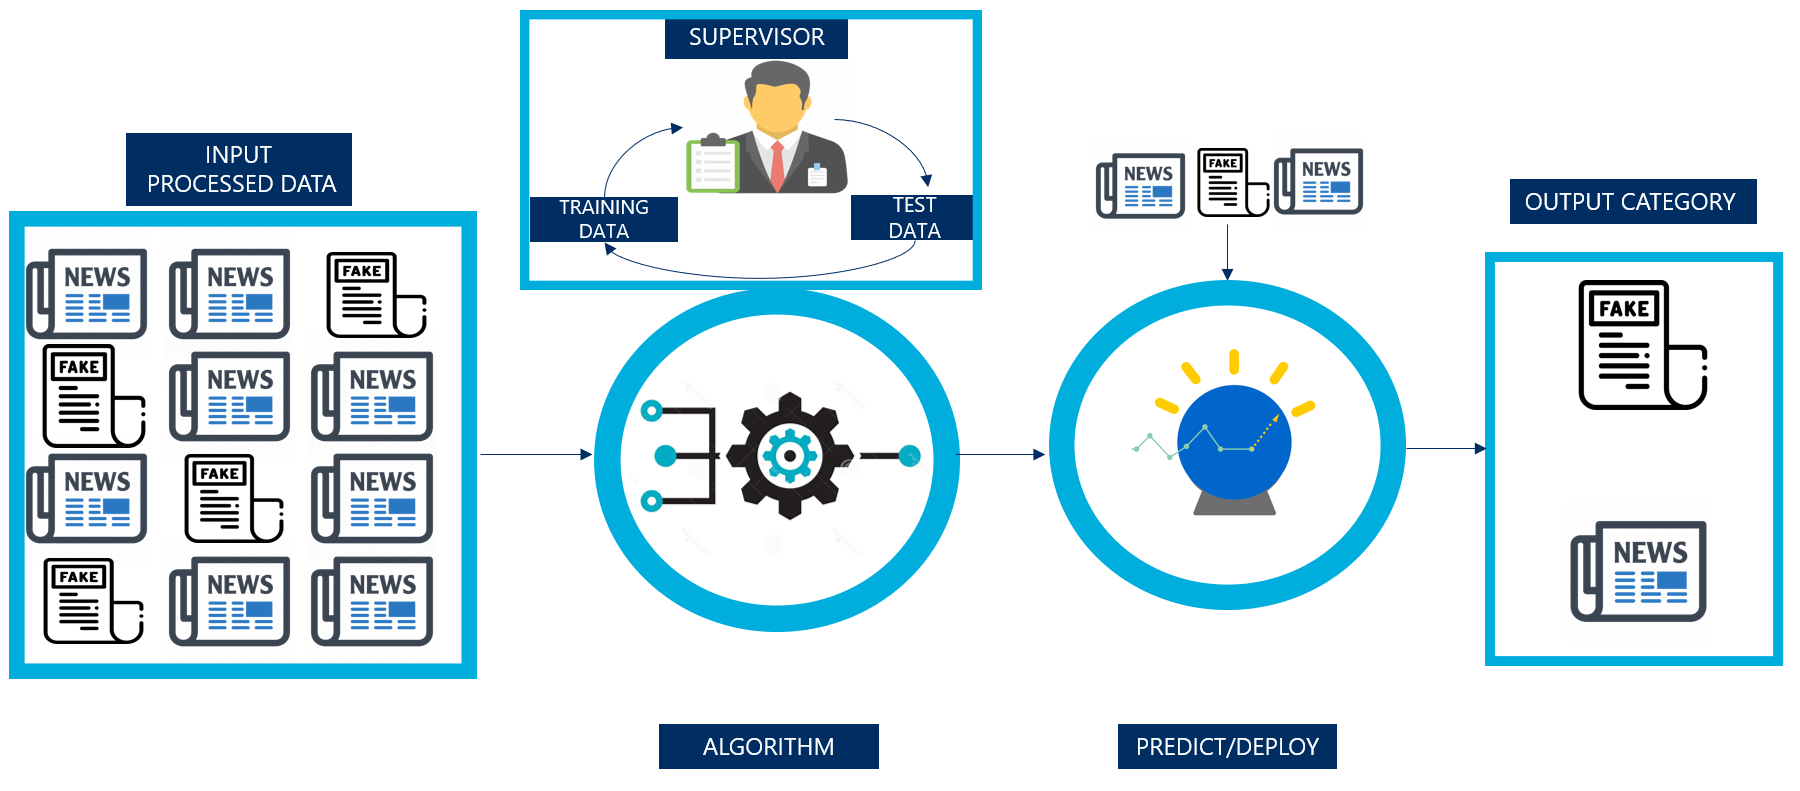

In [1]:
from IPython.display import Image
Image(filename="__results___1_0.png")

## ВВЕДЕНИЕ

### Поддельные новости относятся к дезинформации которая распространяется из уст в уста и традиционные средства массовой информации, а в последнее время через цифровые формы коммуникации, такие как отредактированные видео, мемы, непроверенная реклама и слухи, распространяемые в социальных сетях. Фейковые новости, распространяемые через социальные сети, стали серьезной проблемой, и это может привести к огромному колличеству бед, в результате дезинформации.

## КРАТКОЕ ОПИСАНИЕ НАБОРА ДАННЫХ 

### Этот набор данных состоит из 237 статей состоящих как из фейковых, так и из реальных новостей. Цель данной работы состоит в том, чтобы обучить нашу модель, чтобы она могла правильно предсказать, является ли данная новость правдивой или поддельной. Новостные данные приводятся в двух отдельных наборах данных.

## Шаг 1. Загрузка библиотек и EDA

In [2]:
!pip3 install update
! pip install pymorphy2
! pip install wordcloud
! pip install setmatplotlibformats


ERROR: Could not find a version that satisfies the requirement setmatplotlibformats
ERROR: No matching distribution found for setmatplotlibformats


In [3]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import warnings
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from IPython.display import set_matplotlib_formats
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

set_matplotlib_formats('svg')
warnings.filterwarnings("ignore") 

## EDA

### Загрузка датасетов

In [4]:
df_fake=pd.read_csv("tone_of_panorama_news.csv")
df_true=pd.read_csv("tone_of_lenta_news.csv")

### Визуализация и предварительная предобработка данных

In [5]:
df_fake.head()

,Unnamed: 0,text,link,title,date,author,split_text,tone
0,0,"Глава Римской католической церкви, папа римски...",https://panorama.pub/52021-papa-rimskij-nazval...,Папа римский назвал «средневековым мракобесием...,2020-11-11,Борис Гонтермахер,"['глава', 'римский', 'католический', 'церковь'...",0.582703
1,1,На Дальнем Востоке с 10 ноября начались рейды ...,https://panorama.pub/50913-kazaki-pomogut-gosb...,Уссурийские казаки помогут Департаменту госбез...,2020-11-10,Борис Гонтермахер,"['на', 'дальний', 'восток', 'с', 'ноябрь', 'на...",0.623144
2,2,Министерство здравоохранения России направило ...,https://panorama.pub/51816-vedet-peregovory-o-...,"Россия начала переговоры о закупке 2,5 млн доз...",2020-11-10,Борис Гонтермахер,"['министерство', 'здравоохранение', 'россия', ...",0.625557
3,3,Лидер КПРФ Геннадий Зюганов в эфире радио «Ком...,https://panorama.pub/51960-v-kprf-podderzhali-...,Зюганов поддержал Трампа в борьбе с «неграми и...,2020-11-09,Борис Гонтермахер,"['лидер', 'кпрф', 'геннадий', 'зюганов', 'в', ...",0.617093
4,4,Известный аргентинский футболист и тренер выст...,https://panorama.pub/51933-diego-maradona-tepe...,"Диего Марадона: «Теперь в истории футбола, пом...",2020-11-09,Наши читатели,"['известный', 'аргентинский', 'футболист', 'и'...",0.624652


**Данный датасет содержит восемь столбцов, а именно: фактический текст, ссылку на новость, заголовок, дату публикации, имя автора, разложенный текст и тональность. Для дальнейшей работы понадобится чистка данных.**

In [6]:
df_true.head()

,Unnamed: 0,text,link,title,date,rubrics,split_text,tone
0,0,"В центре Киева в четверг, 1 января, на корресп...",/news/2015/01/01/lifekiev/,На акции в Киеве напали на журналистов LifeNews,1 января 2015,Украина,"['в', 'центр', 'киев', 'в', 'четверг', 'январь...",0.625952
1,1,Президент Белоруссии Александр Лукашенко в нов...,/news/2017/01/01/lukashenko/,Лукашенко призвал белорусов держать порох сухим,1 января 2017,Белоруссия,"['президент', 'белоруссия', 'александр', 'лука...",0.629247
2,2,Ликвидированный в Чечне главарь бандгруппы Мус...,/news/2015/01/01/nak/,НАК сообщил о причастности ликвидированного ба...,1 января 2015,Криминал,"['ликвидировать', 'в', 'чечня', 'главарь', 'ба...",0.609269
3,3,Алжир получил первые восемь истребителей Су-30...,/news/2017/01/01/algerie/,Алжир получил первую партию Су-30 по новому ко...,1 января 2017,Оружие,"['алжир', 'получить', 'первый', 'восемь', 'ист...",0.662722
4,4,Лидер Корейской народной демократической респу...,/news/2013/01/01/korea/,Лидер КНДР впервые за 19 лет поздравил согражд...,1 января 2013,Мир,"['лидер', 'корейский', 'народный', 'демократич...",0.617735


**Данный датасет содержит восемь столбцов, а именно: фактический текст, ссылку на новость, заголовок, дату публикации, тип новостей, разложенный текст и тональность. Для дальнейшей работы понадобится чистка данных.**

In [7]:
display(df_fake.info())
print('\n')
display(df_true.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  121 non-null    int64  
 1   text        121 non-null    object 
 2   link        121 non-null    object 
 3   title       121 non-null    object 
 4   date        121 non-null    object 
 5   author      121 non-null    object 
 6   split_text  121 non-null    object 
 7   tone        121 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 7.7+ KB


None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  116 non-null    int64  
 1   text        116 non-null    object 
 2   link        116 non-null    object 
 3   title       116 non-null    object 
 4   date        116 non-null    object 
 5   rubrics     116 non-null    object 
 6   split_text  116 non-null    object 
 7   tone        116 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 7.4+ KB


None

## Шаг 2. Очистка / подготовка данных 

**Похоже, что темовая колонка возможно, слишком информативна - между поддельными и правдивыми новостными статьями явно нет пересекающихся тем и авторов. Поскольку я хочу построить модель, которая может различать поддельные и правдивые новости на основе их содержания, я откажусь от этой колонки. Более того, лучшим способом обучения модели как на поддельных, так и на правдивых новостных данных будет использование сцепляемых двух видов и их перетасовка. Сначала я должен удалить ненужные для обучения колонки и добавить ярлыки, чтобы убедиться, что мы знаем, какие из них какие.**

In [8]:
df_fake['category'] = 0
df_true['category'] = 1

In [9]:
df_fake=df_fake.drop(["Unnamed: 0", "link","date","author","title","split_text","tone"], axis = 1)
df_true=df_true.drop(["Unnamed: 0", "link","date","split_text","title","rubrics","tone"], axis = 1)
df = pd.concat([df_fake, df_true])
df.head()

,text,category
0,"Глава Римской католической церкви, папа римски...",0
1,На Дальнем Востоке с 10 ноября начались рейды ...,0
2,Министерство здравоохранения России направило ...,0
3,Лидер КПРФ Геннадий Зюганов в эфире радио «Ком...,0
4,Известный аргентинский футболист и тренер выст...,0


<AxesSubplot:xlabel='category', ylabel='count'>

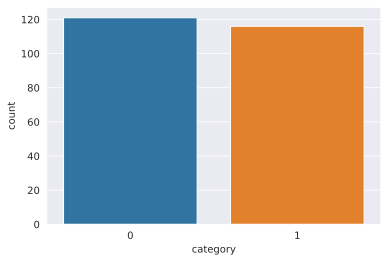

In [10]:
sns.set_style("darkgrid")
sns.countplot(df.category)

In [11]:
df.isna().sum() # Проверка значений 

text        0
category    0
dtype: int64

In [12]:
df.text.count()

237

## Шаг 3. Удаление стоп-слов

Стоп-слова – это слова, которые выкидываются из текста при обработке текста. Когда мы применяем машинное обучение к текстам, такие слова могут добавить много шума, поэтому необходимо избавляться от нерелевантных слов.

Стоп-слова это обычно понимают артикли, междометия, союзы и т.д., которые не несут смысловой нагрузки. При этом надо понимать, что не существует универсального списка стоп-слов, все зависит от конкретного случая.

In [13]:
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/baki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop = set(stopwords.words('russian'))# загружаем список стоп-слов для русского
punctuation = list(string.punctuation)# знаки препинания
stop.update(punctuation)

In [15]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Удаление квадратных скобок 
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Удаление URL 
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
# Удаление игнорируемых слов из текста 
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
# Удаление зашумленного текста 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
# Применить функцию 
df['text']=df['text'].apply(denoise_text)


In [19]:
# Лемматизация
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Функция, которая принимает предложение и получает его лемматизированную версию.
def lemmatize_text(text):
    token_words=word_tokenize(text) 
# Нужно токенизировать предложение, иначе лемматизация вернет все предложение как есть.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

# Применить функцию
df['text']=df['text'].apply(lemmatize_text)

[nltk_data] Downloading package punkt to /home/baki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/baki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


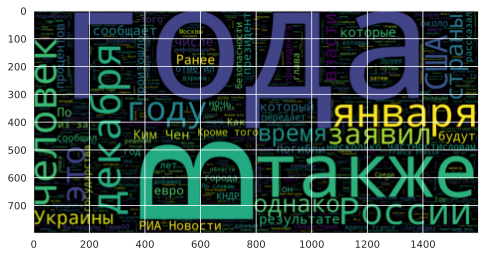

In [20]:
plt.figure(figsize = (8,8)) # Текст который является правдивым
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

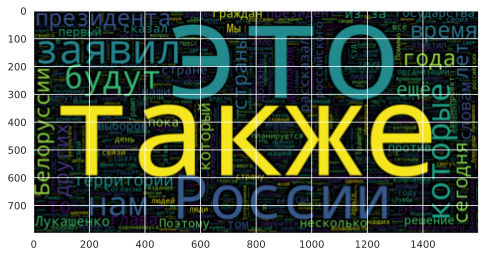

In [21]:
plt.figure(figsize = (8,8)) # Текст, который является поддельным
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')


### Количество символов в текстах

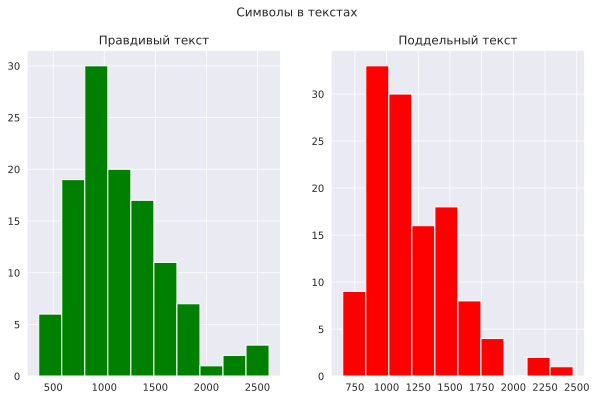

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Правдивый текст')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Поддельный текст')
fig.suptitle('Символы в текстах')
plt.show()


Распределение у обоих, практически не отличается. 1000 символов в тексте является наиболее распространенным в оригинальной и поддельной категорий текст

### Количество слов в каждом тексте

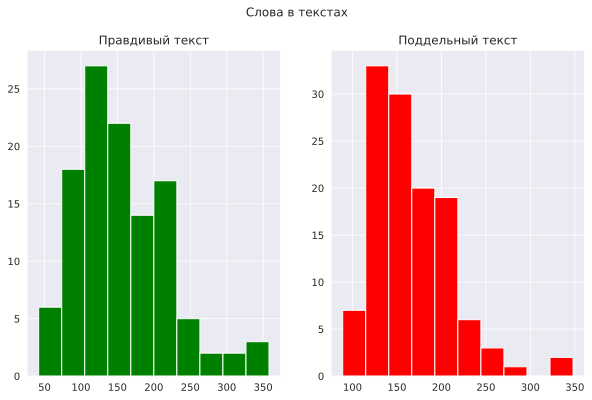

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Правдивый текст')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Поддельный текст')
fig.suptitle('Слова в текстах')
plt.show()


Как и ожидалось, мы видим, что строк столько же, сколько и документов, и мы извлекли более 11 тысяч объектов, или токенов. В качестве примечания, выходные данные выводятся в формате сжатой разреженной строки, который относится к тому, как результирующая матрица tf-idf хранится в памяти. 

## Шаг 4. Обучение модели

In [24]:
df = df.sample(frac = 1)#Случайная перетасовка данных

In [25]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)

In [26]:
df.columns

Index(['text', 'category'], dtype='object')

In [27]:
df.head()

,text,category
0,Соединенных Штатах эксперимент левых активисто...,0
1,700 рабочих крупнейшего Белоруссии предприятия...,0
2,Бывшая первая ракетка мира немец Борис Беккер ...,1
3,1 января ставка тарифов перевозки плацкартных ...,1
4,ночь 1 января Чернигове ( административном цен...,1


In [28]:
df['text']=df['text'].apply(denoise_text)

### Определение зависимых и независимых переменных¶

In [29]:
x = df["text"]
y = df["category"]

In [30]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

### Теперь разделим набор данных на обучающий и тестовый набор данных

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
print('\nОбщее количество образцов для обучения :',x_train.shape[0])
print('Общее количество образцов для тестов :',x_test.shape[0])



Общее количество образцов для обучения : 165
Общее количество образцов для тестов : 72


# Шаг 5. Извлечение признаков


**Среди нескольких распространенных способов извлечения числовых признаков из текста — токенизация, подсчет вхождений и взвешивание терминов tf-idf; Я выбрал взвешивание терминов tf-idf здесь в качестве функции извлечения из этого текста.**

Взвешивание терминов Tf-idf позволяет присваивать важность маркерам, которые фактически несут некоторую информацию, балансируя общую частоту токенов с их частотой в документах. Cначала инициалифицируем объект TfidfVectorizer. Он принимает в качестве входных данных набор строк документа и выводит нормализованные векторы tf-idf; затем, используя fit_transform, как и любые другие трансформаторы и предикторы в scikit-learn, мы можем подогнать векторизатор к данным и трансформировать их. Он имеет возможность использовать max_df для указания частоты отсечения документа для стоп-слов, если они используются. 

Обучаем vectorization на train-данных и сразу преобразем их в вектора с помощью метода fit_transform

In [55]:
#вычисляем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer(max_features = 200)
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

# Топ-10 слов
vectorization.get_feature_names()[:10]


['10', '100', '14', '15', '16', '20', '2009', '2010', '2015', '2016']

In [56]:
xv_train

<165x200 sparse matrix of type '<class 'numpy.float64'>'
	with 3116 stored elements in Compressed Sparse Row format>

### Логическая регрессиия

In [57]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train, y_train)

LogisticRegression()

In [58]:
pred_lr=LR.predict(xv_test)

In [59]:
LR.score(xv_test,y_test)

0.9444444444444444

In [60]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.90      0.97      0.93        29

    accuracy                           0.94        72
   macro avg       0.94      0.95      0.94        72
weighted avg       0.95      0.94      0.94        72



### Классификация дерева решений

In [61]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

In [62]:
pred_dt = DT.predict(xv_test)

In [63]:
DT.score(xv_test, y_test)

0.8055555555555556

In [64]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81        43
           1       0.68      0.97      0.80        29

    accuracy                           0.81        72
   macro avg       0.83      0.83      0.81        72
weighted avg       0.85      0.81      0.81        72



### Классификатор ГБ

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(xv_train, y_train)

GradientBoostingClassifier(random_state=0)

In [66]:
pred_gbc = GBC.predict(xv_test)

In [67]:
GBC.score(xv_test, y_test)

0.8888888888888888

In [68]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90        43
           1       0.78      1.00      0.88        29

    accuracy                           0.89        72
   macro avg       0.89      0.91      0.89        72
weighted avg       0.91      0.89      0.89        72



### Классификатор случайных лесов

In [69]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [70]:
pred_rfc = RFC.predict(xv_test)

In [71]:
RFC.score(xv_test, y_test)

0.9583333333333334

In [72]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        43
           1       0.91      1.00      0.95        29

    accuracy                           0.96        72
   macro avg       0.95      0.97      0.96        72
weighted avg       0.96      0.96      0.96        72



## Шаг 6. Тестирование моделей

In [73]:
def output_lable(n):
    if n == 0:
        return "Фейковые новости"
    elif n == 1:
        return "Правдивые новости"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(denoise_text) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    pred_DT = DT.predict(new_xv_test)
    pred_GBC = GBC.predict(new_xv_test)
    pred_RFC = RFC.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nGBC Prediction: {} \nRFC Prediction: {}".format(output_lable(pred_LR[0]),output_lable(pred_DT[0]), 
                                                                                                              output_lable(pred_GBC[0]), 
                                                                                                              output_lable(pred_RFC[0])))

### Данная новость взята с panorama.pub

https://panorama.pub/news/dmitrij-medvedev-inkognito-proverit-rabotu-moskovskix-alkomarketov-v-nerabochie-dni


In [51]:
news = str(input())
manual_testing(news)

Дмитрий Медведев тайно посетит несколько алкогольных магазинов Москвы в период с 28 октября по 7 ноября. Заместитель председателя Совета безопасности намерен проверить соблюдение торговыми точками требования московских властей о приостановлении работы на период нерабочих дней в столице.  Зампред Совбеза рассказал о своей инициативе в видеоролике, который записал накануне. В своей речи экс-президент призвал жителей Москвы провести длинные выходные дома и полностью отказаться от употребления спиртного. По словам Медведева, алкоголь ослабляет иммунитет и делает организм наиболее уязвимым для индийского штамма коронавируса.  «Дорогие москвичи! В Москве объявлены нерабочие дни и я прошу вас оставаться дома вместе со своими близкими и родными. Как член Совета безопасности и бывший президент России я не могу игнорировать тот факт, что некоторые алкогольные магазины планируют продолжить торговлю своей продукцией во время грядущего локдауна. Это обстоятельство является преступлением против всег

### Данная новость взята с lenta.ru

https://lenta.ru/news/2021/10/31/ubiistvo/

In [81]:
news = str(input())
manual_testing(news)

Житель Кызыла, убивший двух девочек 9 и 14 лет, сбросил их с балкона. Об этом сообщает Telegram-канал SHOT.  Мать девочек воспитывала их одна. Она работала по ночам в кафе и сдавала комнату 23-летнему уроженцу Тес-Хемского района Очуру Санчату. В ночь на 31 октября у него случился конфликт с детьми, которые якобы шумели, и выкинул их с балкона восьмого этажа.  Убийца задержан. Он также подозревается в причинении тяжкого вреда здоровью и угоне машины.  Девочек нашли на улице. Младшая сестра скончалась на месте, старшая умерла в больнице. Возбуждено уголовное дело по статье 105 (убийство двух малолетних лиц) УК РФ. При этом сообщалось, что задержанный был ранее судим по нескольким делам.


LR Prediction: Правдивые новости 
DT Prediction: Правдивые новости 
GBC Prediction: Правдивые новости 
RFC Prediction: Правдивые новости


### Данная новость взята с lenta.ru

https://lenta.ru/news/2021/10/29/bkjfghdkf/

In [75]:
news = str(input())
manual_testing(news)

На въезде в Севастополь начали устанавливать блокпосты для проверки QR-кодов, сообщает РИА Новости.  Работы по обустройству блокпоста развернуты на трассе «Таврида» в районе стелы «Якорь» — въезд со стороны Бахчисарая.  Сотрудник «Севавтодора» также пояснил, что появятся дорожные знаки об ограничении скорости, знаки, обозначающие пункт пропуска. Между встречными полосами, по его словам, разберут ограждение — для разворота машин, которые не прошли контроль.  Заместитель директора департамента общественной безопасности города Алексей Краснокутский отметил, что вся пропускная система начнет работать с 00:00 30 октября.  Ранее сообщалось, что в Севастополе к дежурствам на блокпостах в нерабочие дни привлекут казаков, дружинников и сотрудников МВД. Всего на этой работе будут задействованы около 200 человек.


LR Prediction: Правдивые новости 
DT Prediction: Правдивые новости 
GBC Prediction: Правдивые новости 
RFC Prediction: Правдивые новости


### Данная новость взята с panorama.pub
https://panorama.pub/news/snyatie-nalichnyx-dlya-rossiyan-budet-dostupno-tolko-posle-predyavleniya-qr-koda

In [78]:
news = str(input())
manual_testing(news)


Российский рэп-исполнитель Алишер Валеев, более широко известный как Моргенштерн, попал в списки призывников осени 2021 года и получит повестку на призывной пункт для последующего прохождения военной службы. Об этом журналистам рассказал военный комиссар республики Башкортостан Михаил Блажевич.  "Гражданин Валеев состоит на военном учете и находится в призывном возрасте. Ни о каких отсрочках и льготах нам неизвестно, поэтому ему была направлена повестка на общих основаниях. Ждем его в районном военкомате", - сказал Блажевич.  По данным источников, на самом высоком уровне принято решение о том, что исполнитель должен быть направлен в Кремлевский полк с целью участия в военном параде в ознаменование 77-й годовщины Дня Победы 9 мая 2022 г.  "Это будет ему хорошим уроком в свете его недавних высказываний о Параде и позволит ему скорректировать свою позицию по данному вопросу", - заявил анонимный собеседник.


LR Prediction: Фейковые новости 
DT Prediction: Фейковые новости 
GBC Prediction:

# Заключение

### По проделанной работе, можно сделать вывод, что поставленная цель достигнута. Получаемые результаты, соответствуют действительности новостей. Сами алгоритмы имеют невысокую точность, так как набор данных, имеет маленькую выборку. Однако, некоторые алгоритмы не справляются с определенным текстом новостей  и допускают ошибку, что является следствием плохого обучения и дает возможность на улучшение показателей алгоритмов.
